In [1]:
from matplotlib import pyplot as plt
import glob
import numpy as np
import random
import os
import string
from PIL import Image 
import time
import tensorflow as tf
import pickle
import json


%matplotlib inline

# take an array of shape (n, height, width) or (n, height, width, channels)
# and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)
def vis_square(data, padsize=1, padval=0):
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data)

In [2]:
# Copyright 2016 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
r"""Downloads and converts Flowers data to TFRecords of TF-Example protos.

This module downloads the Flowers data, uncompresses it, reads the files
that make up the Flowers data and creates two TFRecord datasets: one for train
and one for test. Each TFRecord dataset is comprised of a set of TF-Example
protocol buffers, each of which contain a single image and label.

The script should take about a minute to run.

"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import math
import os
import random
import sys

import tensorflow as tf

from datasets import dataset_utils

# The URL where the Flowers data can be downloaded.
# _DATA_URL = 'http://download.tensorflow.org/example_images/flower_photos.tgz'

# The number of images in the validation set.
_NUM_VALIDATION = 800

# Seed for repeatability.
_RANDOM_SEED = 0

# The number of shards per dataset split.
_NUM_SHARDS = 10


class ImageReader(object):
    """Helper class that provides TensorFlow image coding utilities."""

    def __init__(self):
        # Initializes function that decodes RGB JPEG data.
        self._decode_jpeg_data = tf.placeholder(dtype=tf.string)
        self._decode_jpeg = tf.image.decode_jpeg(self._decode_jpeg_data, channels=3)

    def read_image_dims(self, sess, image_data):
        image = self.decode_jpeg(sess, image_data)
        return image.shape[0], image.shape[1]

    def decode_jpeg(self, sess, image_data):
        image = sess.run(self._decode_jpeg,
                         feed_dict={self._decode_jpeg_data: image_data})
        assert len(image.shape) == 3
        assert image.shape[2] == 3
        return image


def _get_filenames_and_classes(dataset_dir):
    """Returns a list of filenames and inferred class names.

    Args:
    dataset_dir: A directory containing a set of subdirectories representing
      class names. Each subdirectory should contain PNG or JPG encoded images.

    Returns:
    A list of image file paths, relative to `dataset_dir` and the list of
    subdirectories, representing class names.
    """
    fish_root = os.path.join(dataset_dir, 'train')
    directories = []
    class_names = []
    for filename in os.listdir(fish_root):
        path = os.path.join(fish_root, filename)
        if os.path.isdir(path):
            directories.append(path)
            class_names.append(filename)

    photo_filenames = []
    for directory in directories:
        for filename in os.listdir(directory):
            if filename.split('.')[-1] in ['jpg', 'png', 'jepg']:
                path = os.path.join(directory, filename)
                photo_filenames.append(path)

    return photo_filenames, sorted(class_names)



def _get_dataset_filename(dataset_dir, split_name, shard_id):
    output_filename = 'fish_%s_%05d-of-%05d.tfrecord' % (
        split_name, shard_id, _NUM_SHARDS)
    return os.path.join(dataset_dir, output_filename)

def _get_bb():
    label_files = ['./label/bet_labels.json',
                 './label/alb_labels.json',
                 './label/yft_labels.json',
                 './label/dol_labels.json',
                 './label/shark_labels.json',
                 './label/lag_labels.json',
                 './label/other_labels.json']
    labels = []
    for i in range(len(label_files)):
        label_file = label_files[i]
        with open(label_file, 'r') as f:
            label_json = json.load(f)
        # extend 合并dict
        labels.extend(label_json)
    return labels

def _convert_dataset(split_name, filenames, bb_labels, class_names_to_ids, dataset_dir):
    """Converts the given filenames to a TFRecord dataset.

    Args:
    split_name: The name of the dataset, either 'train' or 'validation'.
    filenames: A list of absolute paths to png or jpg images.
    class_names_to_ids: A dictionary from class names (strings) to ids
      (integers).
    dataset_dir: The directory where the converted datasets are stored.
    """
    assert split_name in ['train', 'validation']

    num_per_shard = int(math.ceil(len(filenames) / float(_NUM_SHARDS)))
        
    with tf.Graph().as_default():
        image_reader = ImageReader()

        with tf.Session('') as sess:
            for shard_id in range(_NUM_SHARDS):
                output_filename = _get_dataset_filename(dataset_dir, split_name, shard_id)

            with tf.python_io.TFRecordWriter(output_filename) as tfrecord_writer:
                start_ndx = shard_id * num_per_shard
                end_ndx = min((shard_id+1) * num_per_shard, len(filenames))
                for i in range(start_ndx, end_ndx):
                    sys.stdout.write('\r>> Converting image %d/%d shard %d' % (
                        i+1, len(filenames), shard_id))
                    sys.stdout.flush()

                    # Read the filename:
                    image_data = tf.gfile.FastGFile(filenames[i], 'r').read()
                    height, width = image_reader.read_image_dims(sess, image_data)

                    try:
                        bb_label_index = next(index for (index, d) in enumerate(bb_labels) 
                                              if d["filename"] == filenames[i].split(os.sep)[-1])
                        bb_label = bb_labels[bb_label_index]['annotations']
                        bb_label = json.dumps(bb_label)
                        bb_label = bytes(bb_label, 'utf-8')
                    except:
                        bb_label = b''

                    class_name = os.path.basename(os.path.dirname(filenames[i]))
                    class_id = class_names_to_ids[class_name]

                    example = dataset_utils.image_to_tfexample(
                        image_data, b'jpg', height, width, class_id, bb_label)
                    tfrecord_writer.write(example.SerializeToString())

    sys.stdout.write('\n')
    sys.stdout.flush()


def _clean_up_temporary_files(dataset_dir):
    """Removes temporary files used to create the dataset.

    Args:
    dataset_dir: The directory where the temporary files are stored.
    """
    filename = _DATA_URL.split('/')[-1]
    filepath = os.path.join(dataset_dir, filename)
    tf.gfile.Remove(filepath)

    tmp_dir = os.path.join(dataset_dir, 'flower_photos')
    tf.gfile.DeleteRecursively(tmp_dir)


def _dataset_exists(dataset_dir):
    for split_name in ['train', 'validation']:
        for shard_id in range(_NUM_SHARDS):
            output_filename = _get_dataset_filename(
                dataset_dir, split_name, shard_id)
            if not tf.gfile.Exists(output_filename):
                return False
    return True


def run(dataset_dir):
    """Runs the download and conversion operation.

    Args:
    dataset_dir: The dataset directory where the dataset is stored.
    """
    if not tf.gfile.Exists(dataset_dir):
        tf.gfile.MakeDirs(dataset_dir)

    if _dataset_exists(dataset_dir):
        print('Dataset files already exist. Exiting without re-creating them.')
        return

#     dataset_utils.download_and_uncompress_tarball(_DATA_URL, dataset_dir)
    photo_filenames, class_names = _get_filenames_and_classes(dataset_dir)
    class_names_to_ids = dict(zip(class_names, range(len(class_names))))

    # Divide into train and test:
    random.seed(_RANDOM_SEED)
    random.shuffle(photo_filenames)
    training_filenames = photo_filenames[_NUM_VALIDATION:]
    validation_filenames = photo_filenames[:_NUM_VALIDATION]
    
    bb_labels = _get_bb()

    # First, convert the training and validation sets.
    _convert_dataset('train', training_filenames, bb_labels, class_names_to_ids, dataset_dir)
    _convert_dataset('validation', validation_filenames, bb_labels, class_names_to_ids, dataset_dir)

    # Finally, write the labels file:
    labels_to_class_names = dict(zip(range(len(class_names)), class_names))
    dataset_utils.write_label_file(labels_to_class_names, dataset_dir)

#     _clean_up_temporary_files(dataset_dir)
    print('\nFinished converting the fish dataset!')



In [3]:
run('./input/')

>> Converting image 2977/2977 shard 9
>> Converting image 800/800 shard 9

Finished converting the fish dataset!


In [4]:
# Copyright 2016 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""Provides data for the fish dataset.

The dataset scripts used to create the dataset can be found at:
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import tensorflow as tf

from datasets import dataset_utils

slim = tf.contrib.slim

_FILE_PATTERN = 'fish_%s_*.tfrecord'

SPLITS_TO_SIZES = {'train': 2977, 'validation': 800}

_NUM_CLASSES = 8

_ITEMS_TO_DESCRIPTIONS = {
    'image': 'A color image of varying size.',
    'label': 'A single integer between 0 and 7',
    'bb_label': 'A list of boundary boxes'
}


def get_split(split_name, dataset_dir, file_pattern=None, reader=None):
    """Gets a dataset tuple with instructions for reading fish.

    Args:
    split_name: A train/validation split name.
    dataset_dir: The base directory of the dataset sources.
    file_pattern: The file pattern to use when matching the dataset sources.
      It is assumed that the pattern contains a '%s' string so that the split
      name can be inserted.
    reader: The TensorFlow reader type.

    Returns:
    A `Dataset` namedtuple.

    Raises:
    ValueError: if `split_name` is not a valid train/validation split.
    """
    if split_name not in SPLITS_TO_SIZES:
        raise ValueError('split name %s was not recognized.' % split_name)

    if not file_pattern:
        file_pattern = _FILE_PATTERN
        file_pattern = os.path.join(dataset_dir, file_pattern % split_name)

    # Allowing None in the signature so that dataset_factory can use the default.
    if reader is None:
        reader = tf.TFRecordReader

    keys_to_features = {
        'image/encoded': tf.FixedLenFeature((), tf.string, default_value=''),
        'image/format': tf.FixedLenFeature((), tf.string, default_value='png'),
        'image/class/label': tf.FixedLenFeature(
            [], tf.int64, default_value=tf.zeros([], dtype=tf.int64)),
        'image/bb_label': tf.FixedLenFeature((), tf.string, default_value=b''),
    }

    items_to_handlers = {
        'image': slim.tfexample_decoder.Image(),
        'label': slim.tfexample_decoder.Tensor('image/class/label'),
        'bb_label': slim.tfexample_decoder.Tensor('image/bb_label'),
    }

    decoder = slim.tfexample_decoder.TFExampleDecoder(
        keys_to_features, items_to_handlers)

    labels_to_names = None
    if dataset_utils.has_labels(dataset_dir):
        labels_to_names = dataset_utils.read_label_file(dataset_dir)

    return slim.dataset.Dataset(
        data_sources=file_pattern,
        reader=reader,
        decoder=decoder,
        num_samples=SPLITS_TO_SIZES[split_name],
        items_to_descriptions=_ITEMS_TO_DESCRIPTIONS,
        num_classes=_NUM_CLASSES,
        labels_to_names=labels_to_names)


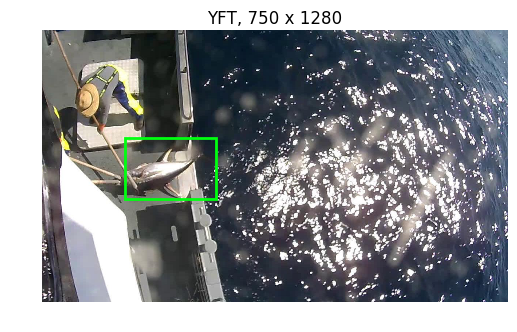

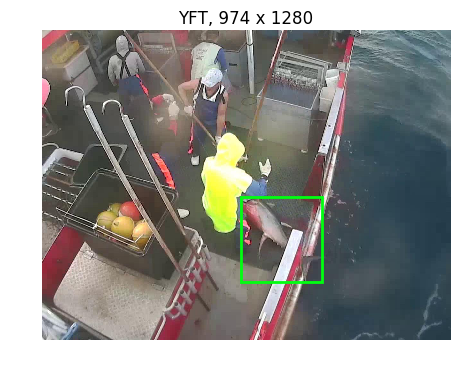

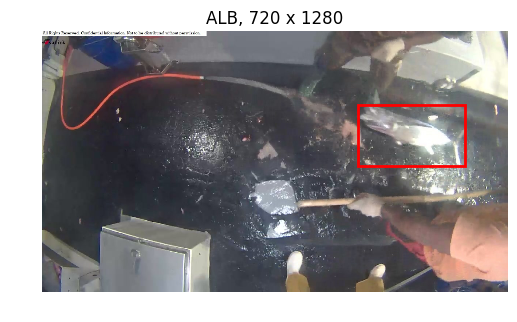

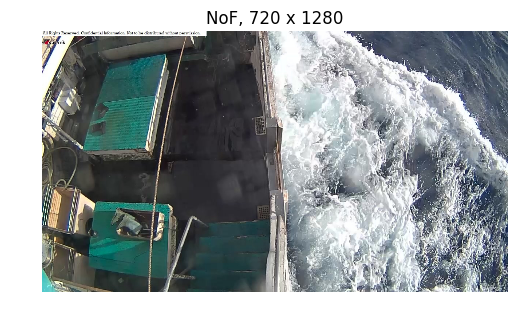

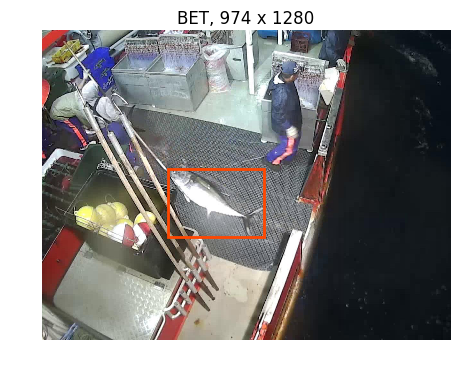

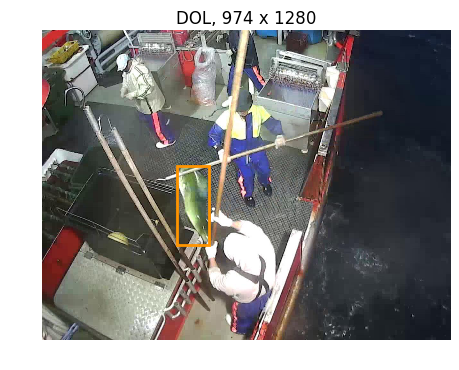

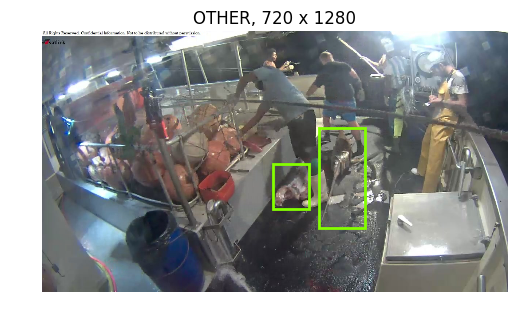

In [5]:
fish_data_dir = 'input'
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()

with tf.Graph().as_default(): 
    dataset = get_split('train', fish_data_dir)
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=32, common_queue_min=1)
    image, label, bb_label = data_provider.get(['image', 'label', 'bb_label'])
    
    with tf.Session() as sess:    
        with slim.queues.QueueRunners(sess):
            for i in range(7):
                np_image, np_label, np_bb_label = sess.run([image, label, bb_label])
                height, width, _ = np_image.shape
                class_name = name = dataset.labels_to_names[np_label]
                
#                 from PIL import Image
#                 Image.fromarray(np_image)
                
                plt.figure()
                plt.imshow(np_image)
                currentAxis = plt.gca()
                j = 0
                if np_bb_label is not b'':
                    np_bb_label_lst = json.loads((np_bb_label.decode('utf-8')))
                    for rect in np_bb_label_lst:
                        _x, _y, _width, _height = rect['x'], rect['y'], rect['width'], rect['height']
                        coords = (_x*width, _y*height), _width*width, _height*height
                        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=colors[np_label], linewidth=2))
                        j += 1
                plt.title('%s, %d x %d' % (name, height, width))
                plt.axis('off')
                plt.show()

In [6]:
#count images without bb_label


# filenames, classes = _get_filenames_and_classes('input')
# bb_labels = _get_bb()
# count = 0
# for path in filenames:
#     filename = path.split(os.sep)[-1]
#     if not any(d['filename'] == filename for d in bb_labels):
#         count += 1
#         print(path)

In [32]:
from preprocessing import inception_preprocessing
import tensorflow as tf

slim = tf.contrib.slim


def load_batch(dataset, batch_size=32, height=299, width=299, is_training=False):
    """Loads a single batch of data.
    
    Args:
      dataset: The dataset to load.
      batch_size: The number of images in the batch.
      height: The size of each image after preprocessing.
      width: The size of each image after preprocessing.
      is_training: Whether or not we're currently training or evaluating.
    
    Returns:
      images: A Tensor of size [batch_size, height, width, 3], image samples that have been preprocessed.
      images_raw: A Tensor of size [batch_size, height, width, 3], image samples that can be used for visualization.
      labels: A Tensor of size [batch_size], whose values range between 0 and dataset.num_classes.
    """
#     data_provider = slim.dataset_data_provider.DatasetDataProvider(
#         dataset, common_queue_capacity=32,
#         common_queue_min=8)
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
    dataset, common_queue_capacity=32,
    common_queue_min=8)
    image_raw, label = data_provider.get(['image', 'label'])
    
    # Preprocess image for usage by Inception.
    image = inception_preprocessing.preprocess_image(image_raw, height, width, is_training=is_training)
    
    # Preprocess the image for display purposes.
    image_raw = tf.expand_dims(image_raw, 0)
    image_raw = tf.image.resize_images(image_raw, [height, width])
    image_raw = tf.squeeze(image_raw)

    # Batch it up.
    images, images_raw, labels = tf.train.batch(
          [image, image_raw, label],
          batch_size=batch_size,
          num_threads=1,
          capacity=2 * batch_size)
    
    return images, images_raw, labels



In [44]:
# Note that this may take several minutes.

import os

from nets import inception
from preprocessing import inception_preprocessing

slim = tf.contrib.slim
image_size = inception.inception_v3.default_image_size


def get_init_fn():
    """Returns a function run by the chief worker to warm-start the training."""
    checkpoint_exclude_scopes=["InceptionV3/Logits", "InceptionV3/AuxLogits"]
    
    exclusions = [scope.strip() for scope in checkpoint_exclude_scopes]

    variables_to_restore = []
    for var in slim.get_model_variables():
        excluded = False
        for exclusion in exclusions:
            if var.op.name.startswith(exclusion):
                excluded = True
                break
        if not excluded:
            variables_to_restore.append(var)

    return slim.assign_from_checkpoint_fn(
        os.path.join(checkpoints_dir, 'inception_v3.ckpt'),
        variables_to_restore)


train_dir = 'tmp/fish/inception_finetuned/'
fish_data_dir = 'tmp/fish/dataset'
checkpoints_dir = 'tmp/fish/my_checkpoints'

with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    
    dataset = get_split('train', fish_data_dir)
    
    images, _, labels = load_batch(dataset, height=image_size, width=image_size)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception.inception_v3_arg_scope()):
        logits, _ = inception.inception_v3(images, num_classes=dataset.num_classes, is_training=True)
        
    # Specify the loss function:
    one_hot_labels = slim.one_hot_encoding(labels, dataset.num_classes)
    slim.losses.softmax_cross_entropy(logits, one_hot_labels)
    total_loss = slim.losses.get_total_loss()

    # Create some summaries to visualize the training process:
    tf.scalar_summary('losses/Total Loss', total_loss)
  
    # Specify the optimizer and create the train op:
    optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
    train_op = slim.learning.create_train_op(total_loss, optimizer)
    
    # Run the training:
    final_loss = slim.learning.train(
        train_op,
        logdir=train_dir,
        init_fn=get_init_fn(),
        log_every_n_steps = 100,
        number_of_steps=500)
        
  
print('Finished training. Last batch loss %f' % final_loss)

Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
Instructions for updating:
Please switch to tf.summary.FileWriter. The interface and behavior is the same; this is just a rename.


RuntimeError: generator didn't yield

In [43]:
from tensorflow.python.training import supervisor
sv = supervisor.Supervisor()

In [38]:
images

<tf.Tensor 'batch:0' shape=(32, 229, 229, 3) dtype=float32>

In [25]:
load_batch(dataset, height=229, width=229)

(<tf.Tensor 'batch_2:0' shape=(32, 229, 229, 3) dtype=float32>,
 <tf.Tensor 'batch_2:1' shape=(32, 229, 229, 3) dtype=float32>,
 <tf.Tensor 'batch_2:2' shape=(32,) dtype=int64>)